In [ ]:
!nvidia-smi

Fri Jan  3 23:01:17 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Install YOLOv8 and roboflow packages


In [ ]:
!pip install ultralytics==8.2.103 -q
!pip install roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00


In [ ]:
import os
import glob
from IPython.display import display, Image
from ultralytics import YOLO
from roboflow import Roboflow
import pandas as pd

HOME = os.getcwd()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Download dataset using Roboflow

In [ ]:
!mkdir -p {HOME}/datasets
os.chdir(f"{HOME}/datasets")

rf = Roboflow(api_key="o3tgZZQQb4g7tXePDL3E")
project = rf.workspace("my-workspace-uqiud").project("pallet-detection-pryqx")
version = project.version(1)
dataset = version.download("yolov8")
os.chdir(HOME)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pallet-Detection-1 in yolov8:: 100%|██████████| 2496/2496 [00:00<00:00, 6218.06it/s]


Train segmentation model


In [ ]:
os.environ['WANDB_MODE'] = 'disabled'
!yolo task=segment mode=train model=yolov8m-seg.pt data={dataset.location}/data.yaml epochs=25

100% 52.4M/52.4M [00:02<00:00, 24.7MB/s]
New https://pypi.org/project/ultralytics/8.3.57 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/content/datasets/Pallet-Detection-1/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False

Display training results


Confusion Matrix (Training Results):


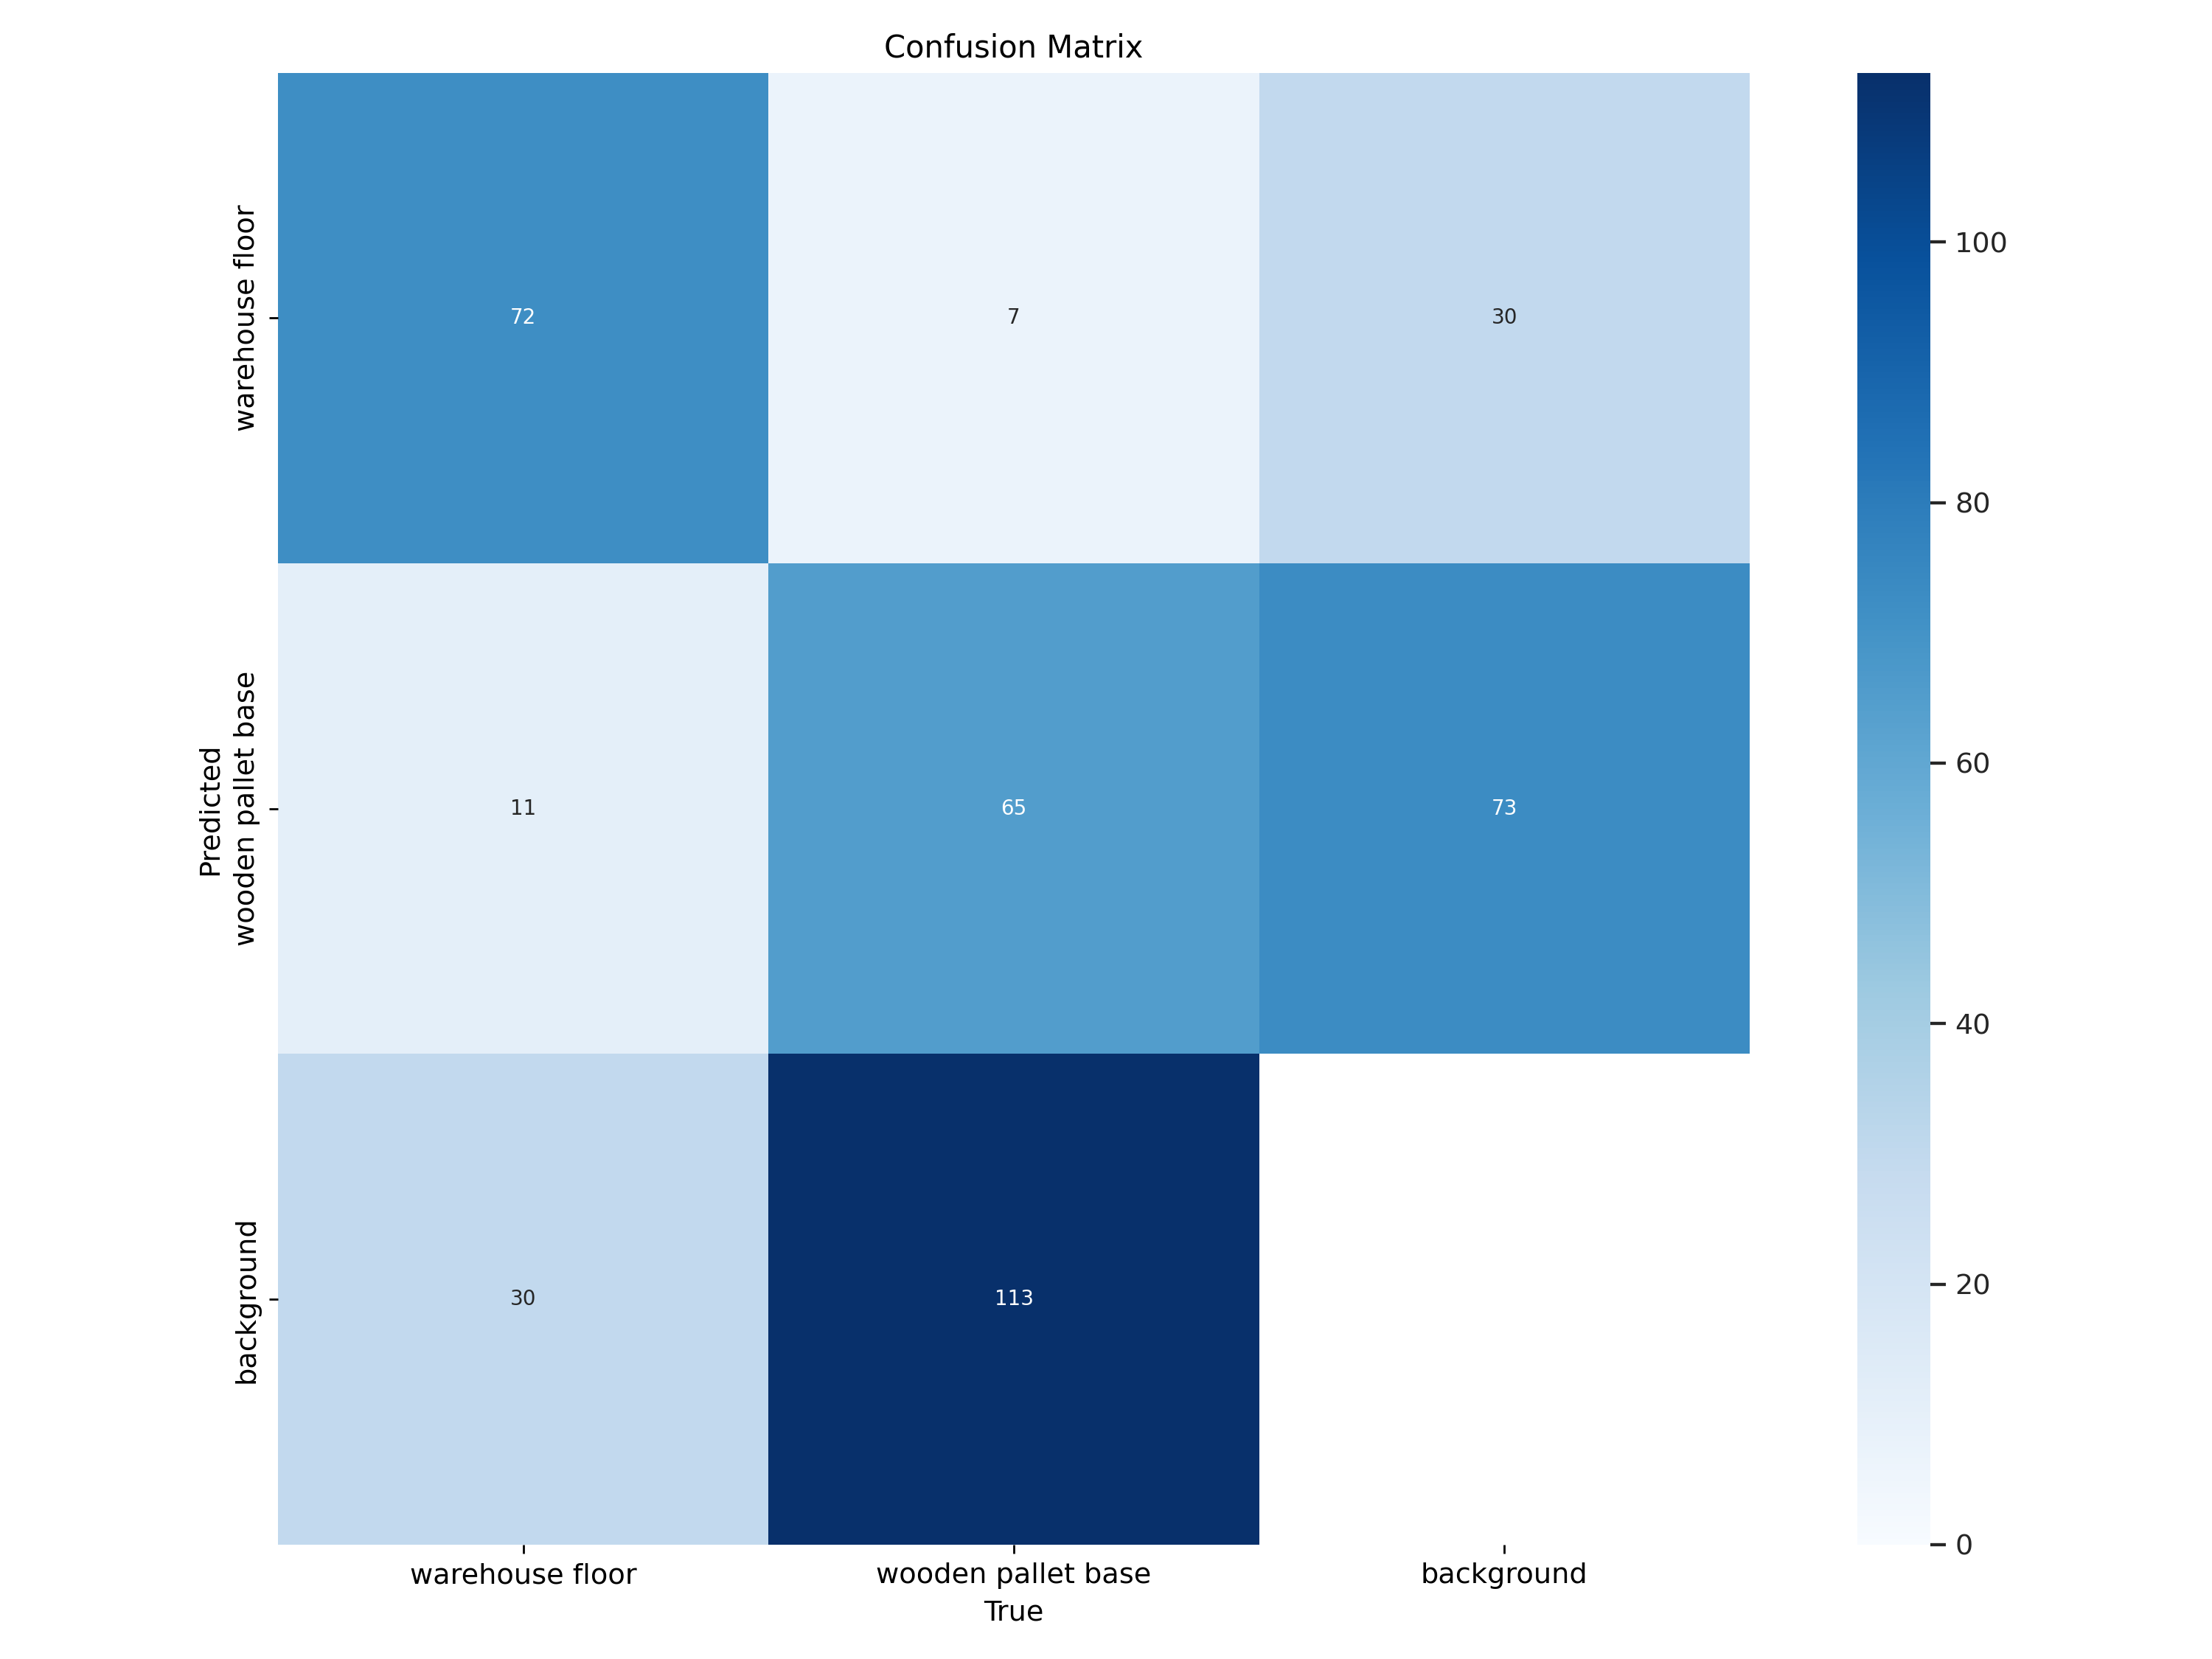

Training Results Metrics:


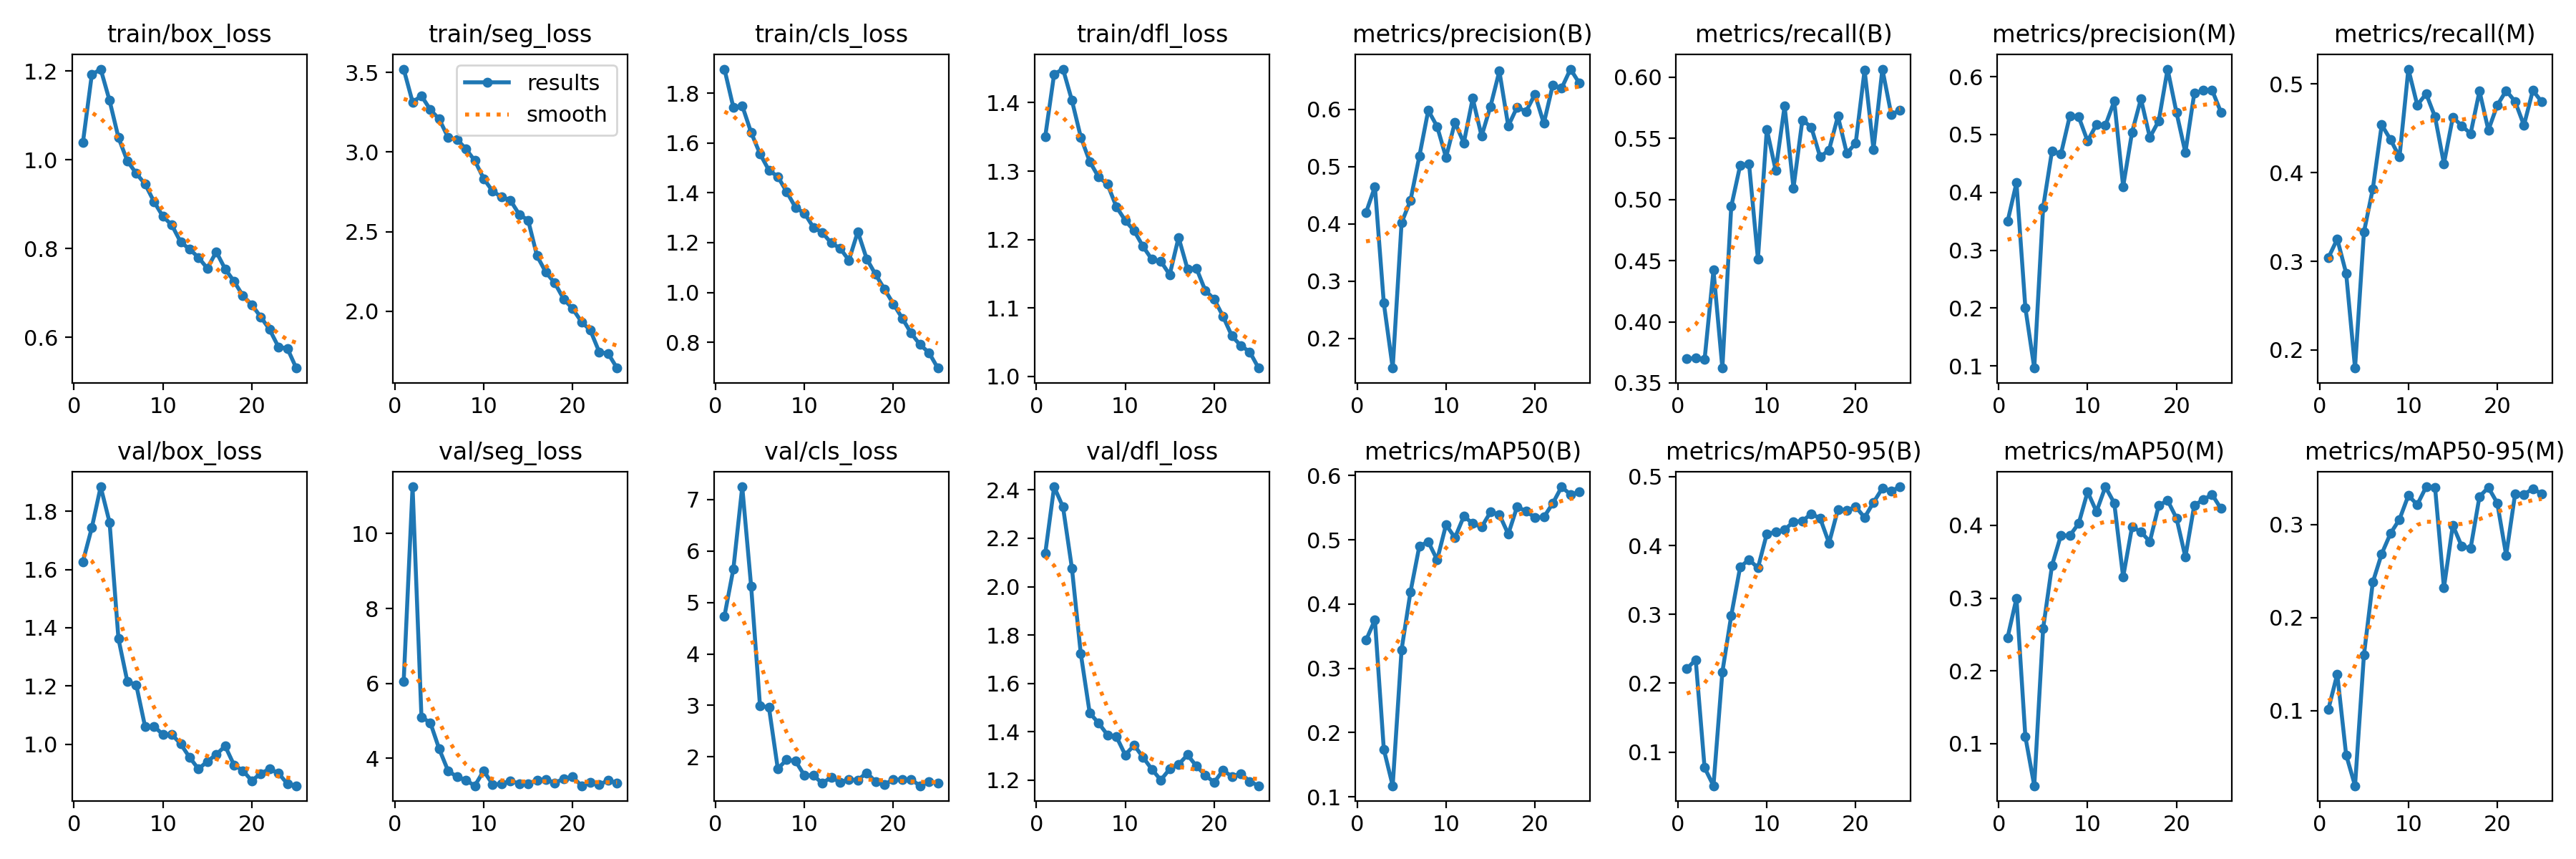

Validation Batch Predictions:


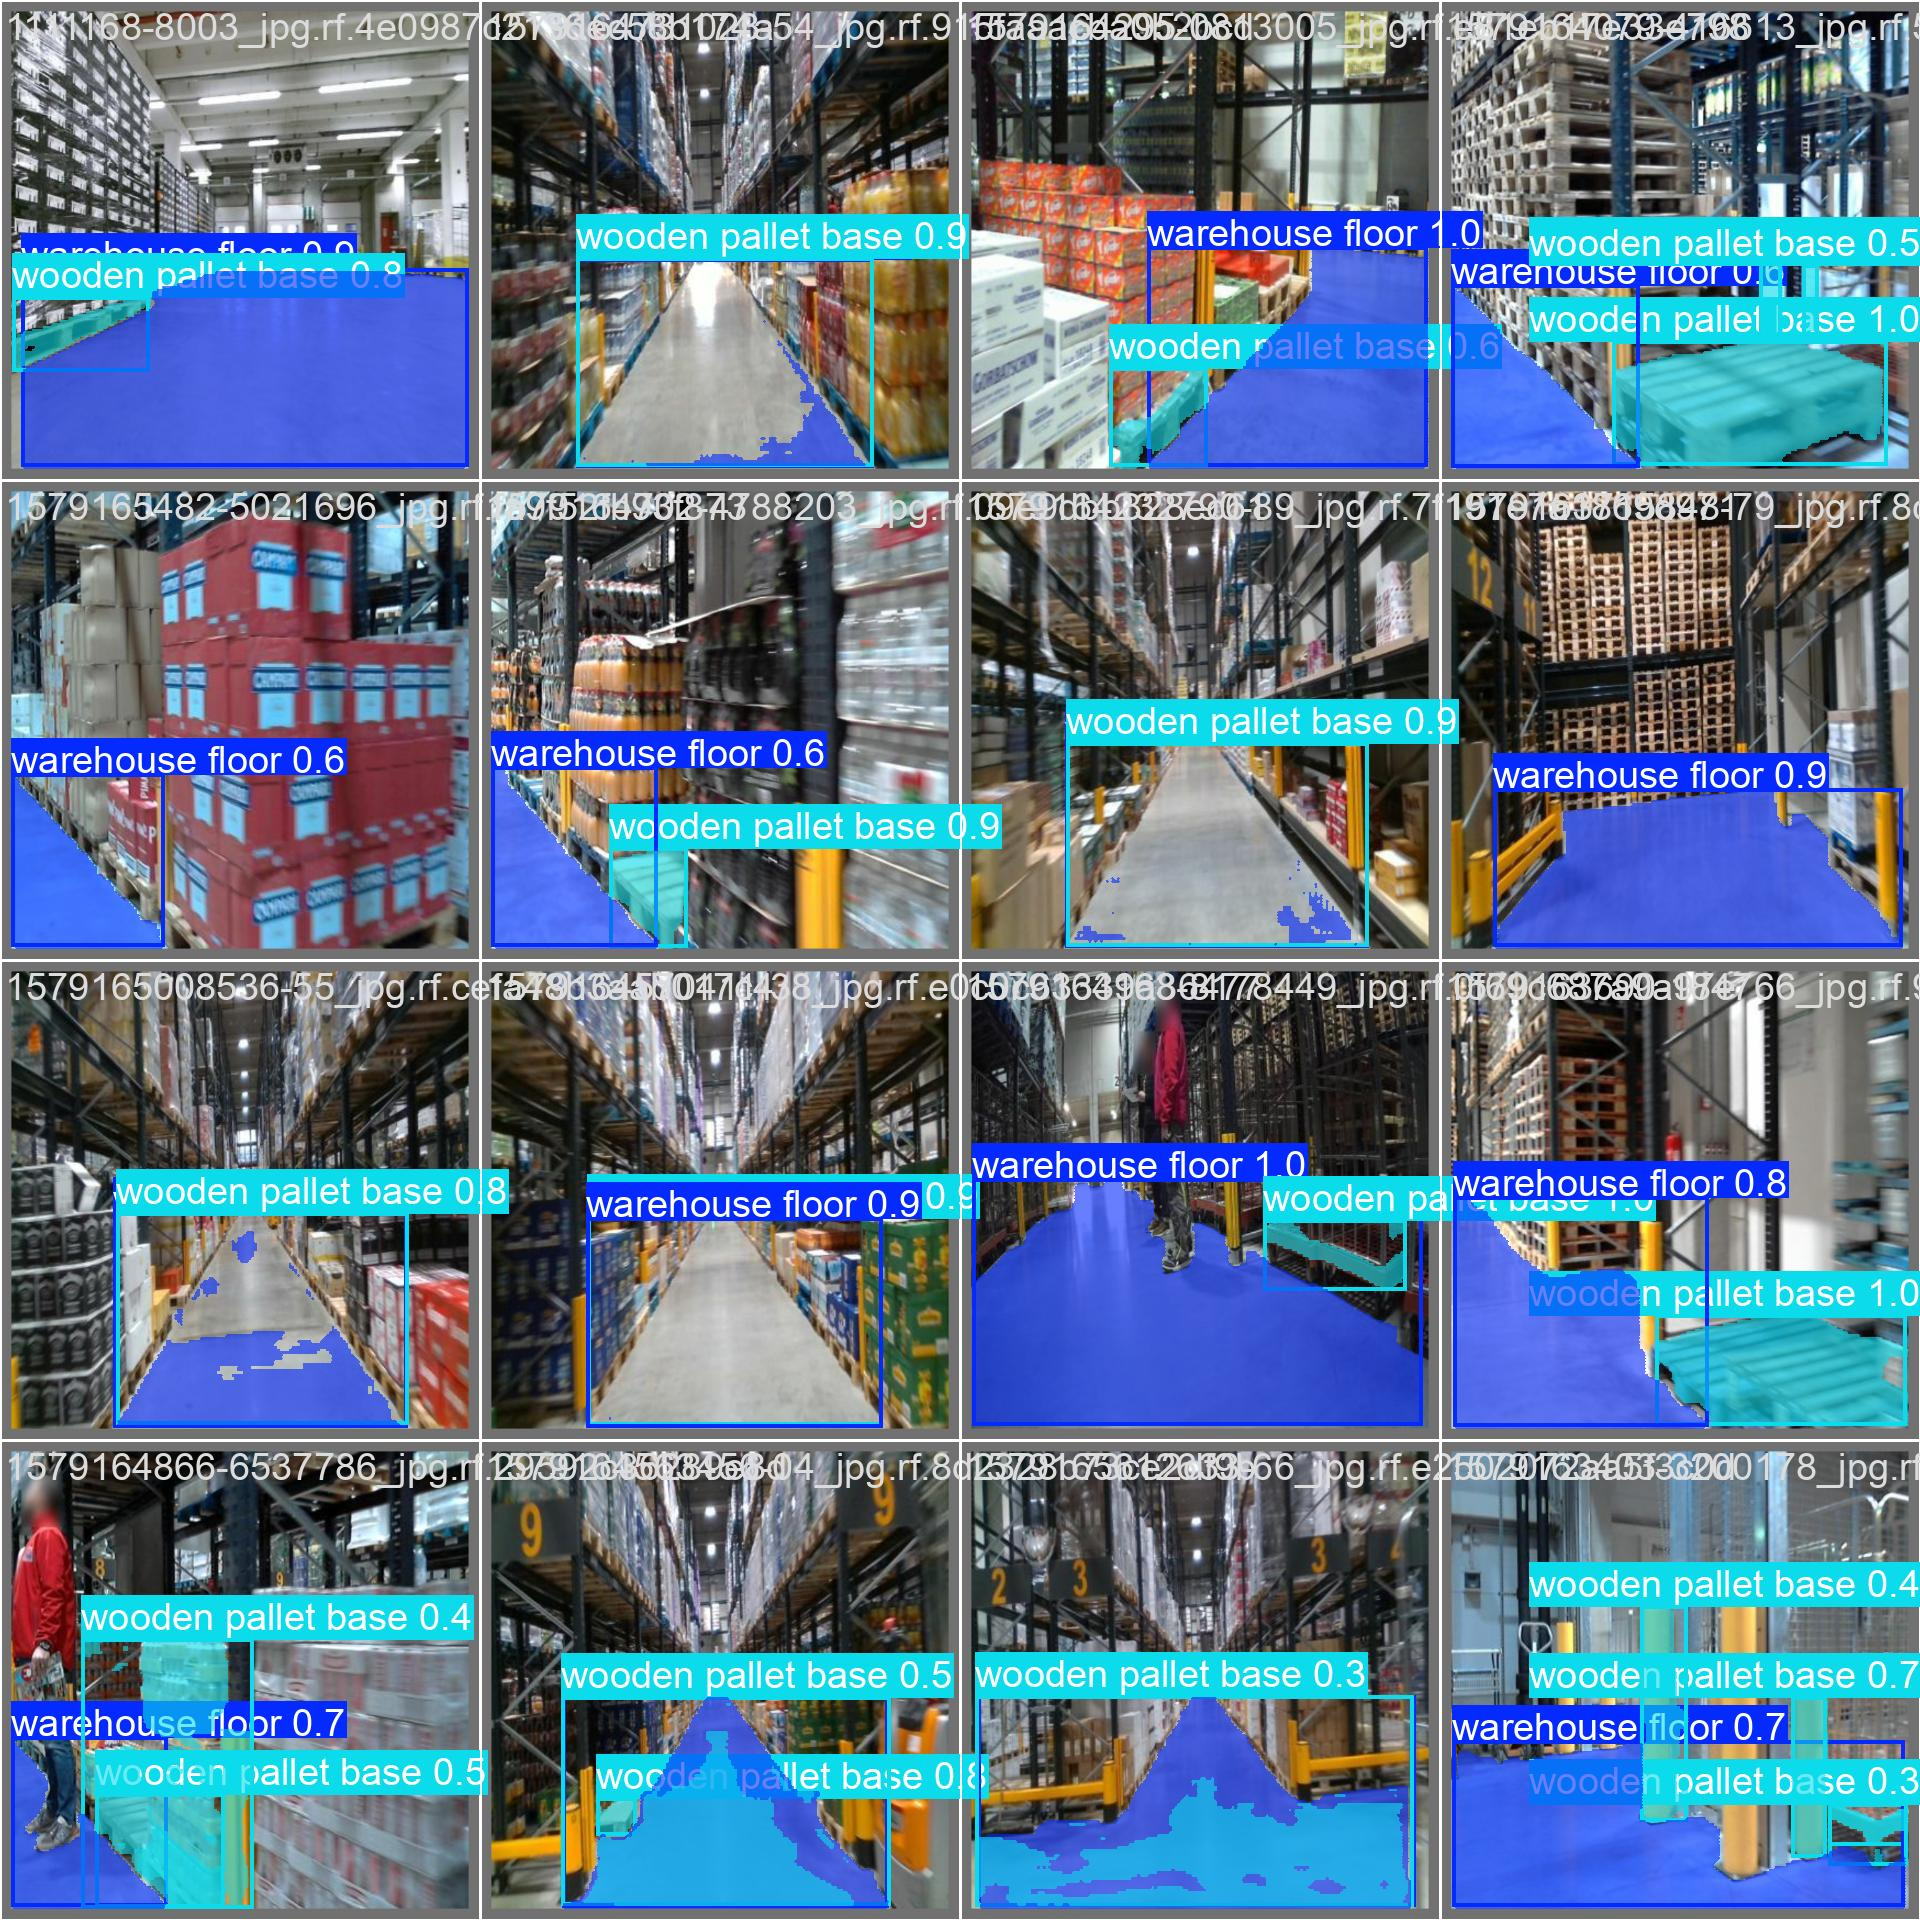

In [ ]:
print("Confusion Matrix (Training Results):")
display(Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600))

print("Training Results Metrics:")
display(Image(filename=f'{HOME}/runs/segment/train/results.png', width=600))

print("Validation Batch Predictions:")
display(Image(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600))

Validate segmentation model

In [ ]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,223,542 parameters, 0 gradients, 110.0 GFLOPs
val: Scanning /content/datasets/Pallet-Detection-1/valid/labels.cache... 104 images, 4 backgrounds, 0 corrupt: 100% 104/104 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/Pallet-Detection-1/valid/images/1564563110-5815756_jpg.rf.15ca954048c2d171024a75a124a336e3.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Pallet-Detection-1/valid/images/1574675843344-91_jpg.rf.b9122968b55c24730036d247fc402d7c.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Pallet-Detection-1/valid/images/1574681866-4870656_jpg.rf.9db91a5c3a706355b9a7514a7701d959.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Pallet-Detection-1/valid/images/1576595800-150642_jpg.rf.41d98fbd158717c5f527d21f307ce451.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/Pallet-Detection-1/val

Display validation results

Segmentation Validation Confusion Matrix:


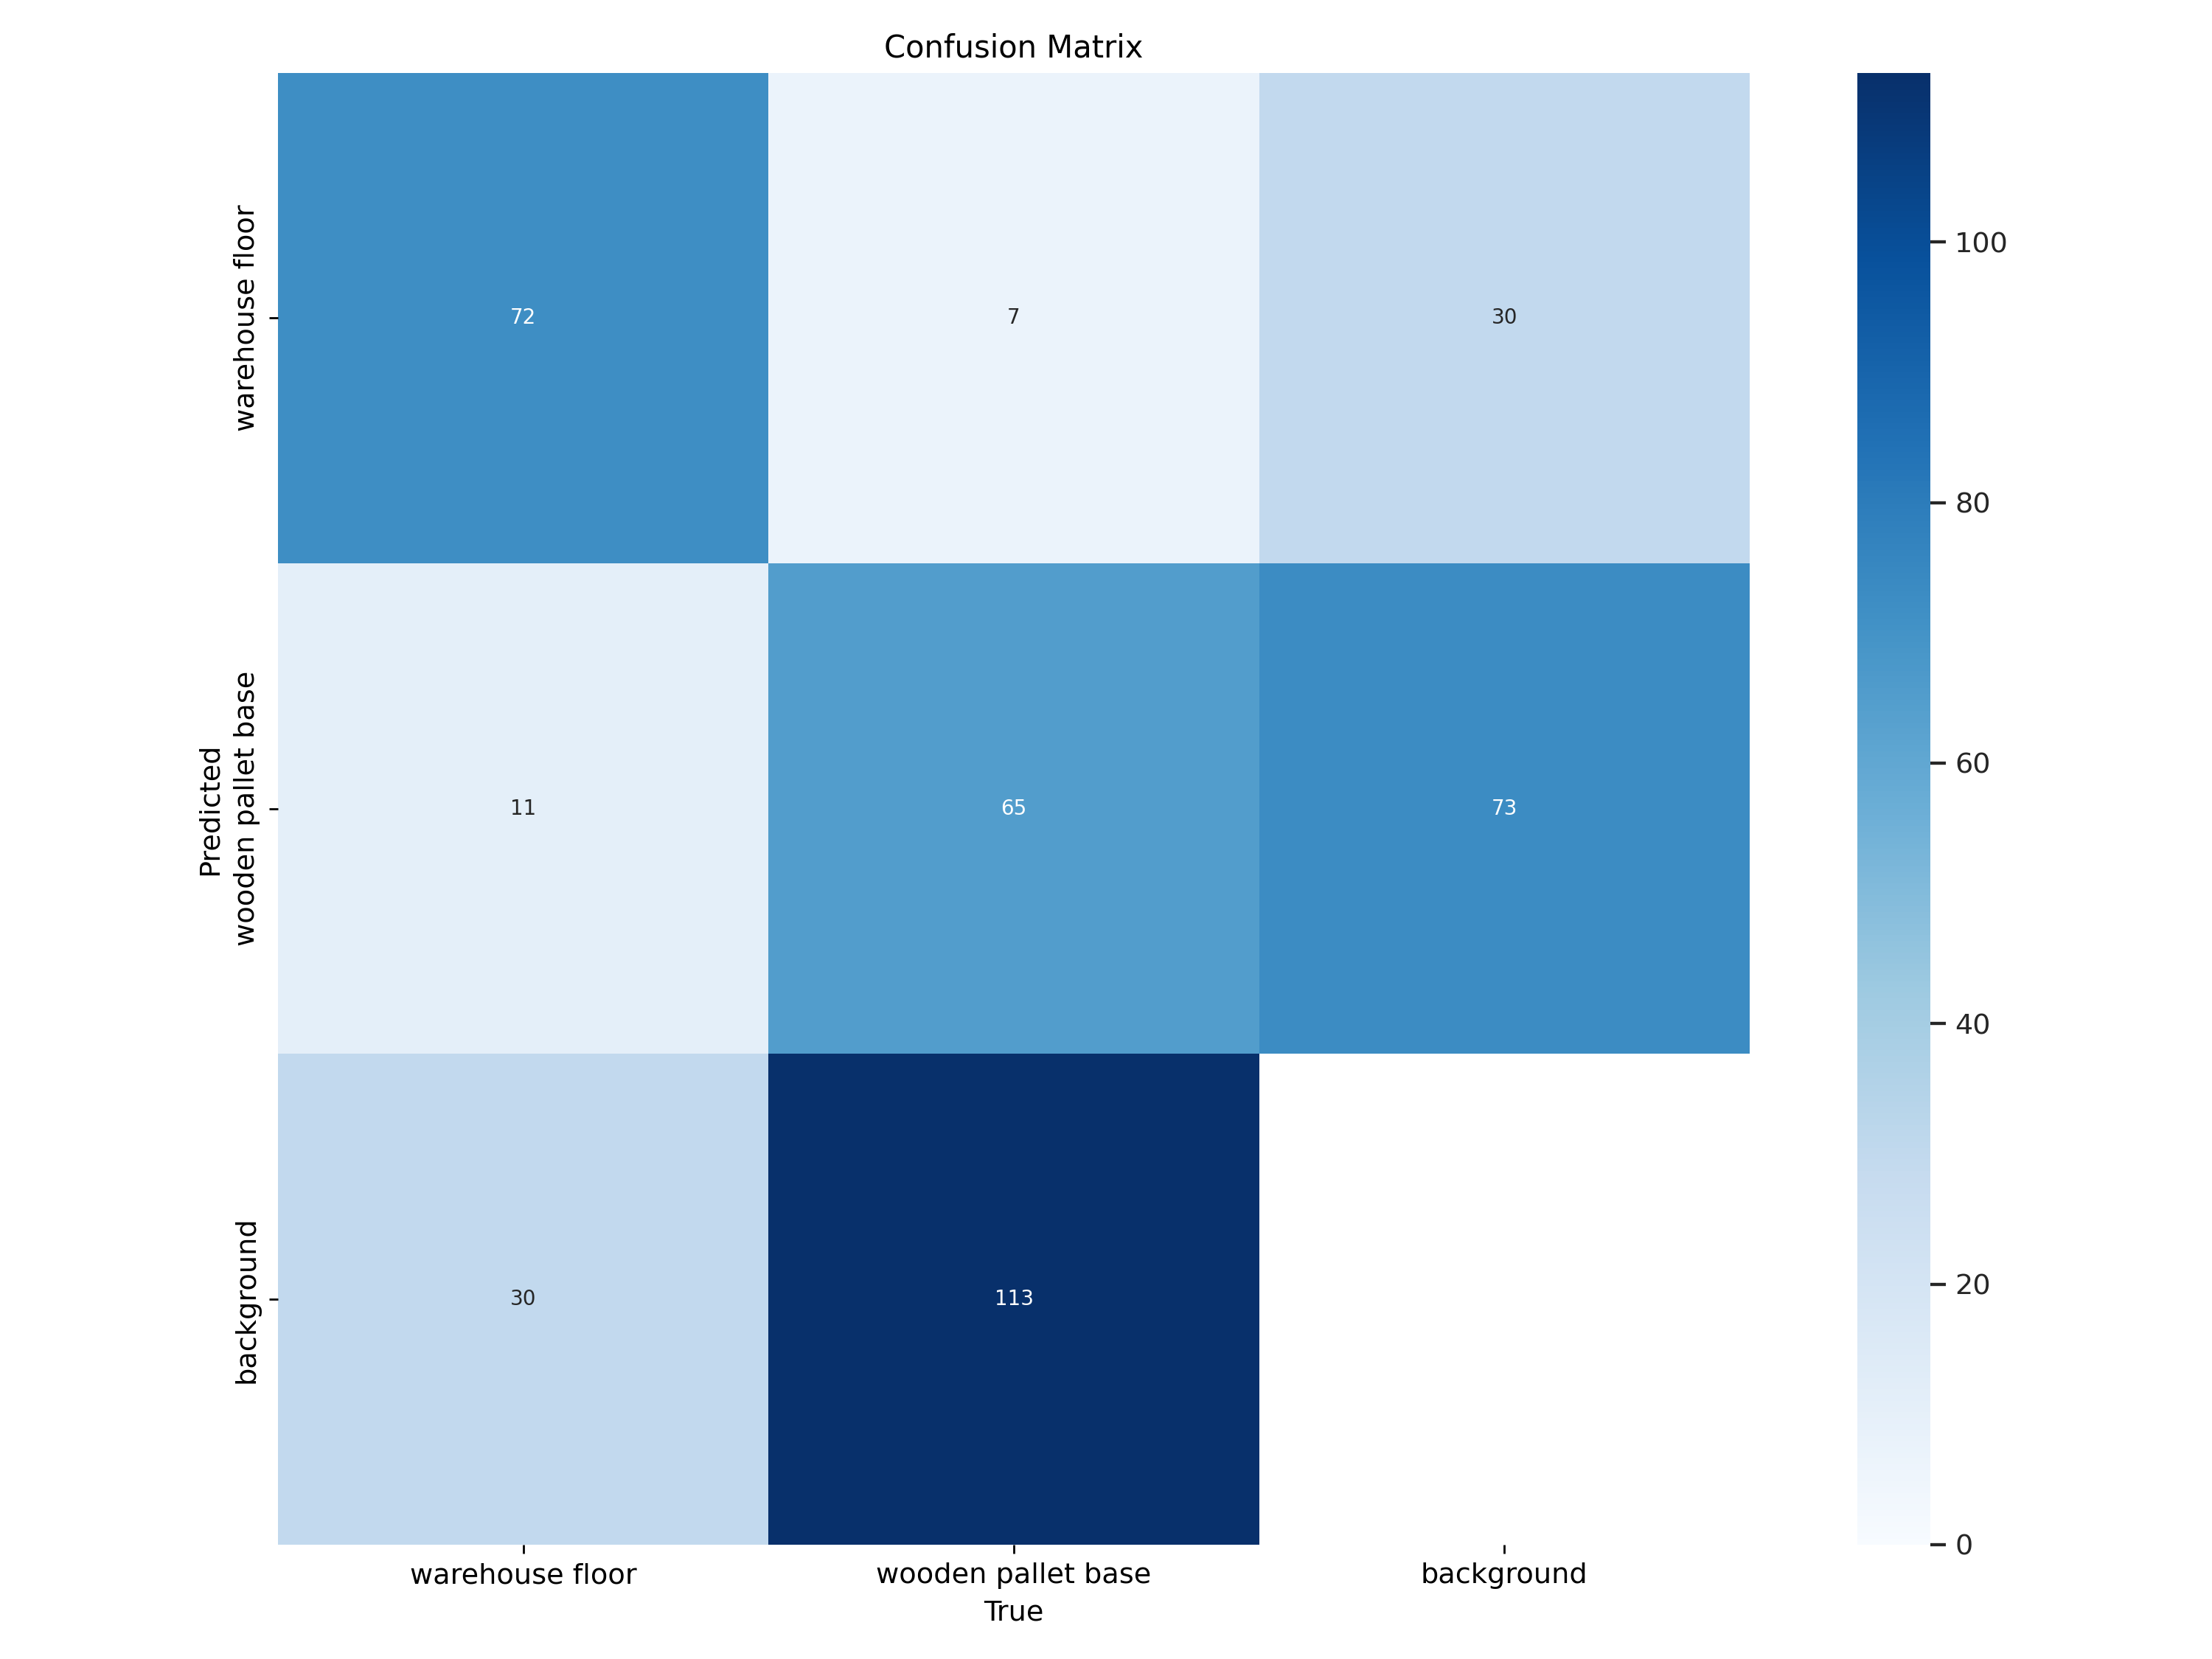

In [ ]:
print("Segmentation Validation Confusion Matrix:")
seg_val_path = f"{HOME}/runs/segment/val/confusion_matrix.png"
display(Image(filename=seg_val_path, width=600))

Perform predictions on test data

In [ ]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,223,542 parameters, 0 gradients, 110.0 GFLOPs

image 1/52 /content/datasets/Pallet-Detection-1/test/images/1000736-6303_jpg.rf.e88e71f7500b89fe4452bc9fbaa50fa3.jpg: 640x640 2 warehouse floors, 2 wooden pallet bases, 45.7ms
image 2/52 /content/datasets/Pallet-Detection-1/test/images/1366296-2234_jpg.rf.9a8aa7cc48575aa2bd6552eb5803a1ee.jpg: 640x640 1 warehouse floor, 1 wooden pallet base, 40.4ms
image 3/52 /content/datasets/Pallet-Detection-1/test/images/1564562881-697836_jpg.rf.81b40d3baa19ecf84b0df10fd4cc9056.jpg: 640x640 2 warehouse floors, 40.3ms
image 4/52 /content/datasets/Pallet-Detection-1/test/images/1564562908-175581_jpg.rf.af574a6782a84218b21ee8ae255ceb88.jpg: 640x640 2 warehouse floors, 2 wooden pallet bases, 40.3ms
image 5/52 /content/datasets/Pallet-Detection-1/test/images/1564564269-5367193_jpg.rf.5a83eaf752badc16b8c149fab1f92f11.jpg: 640x640 

Display prediction results

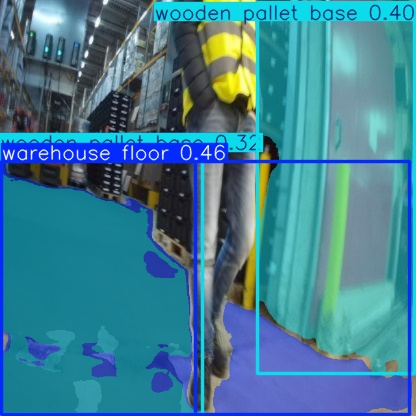

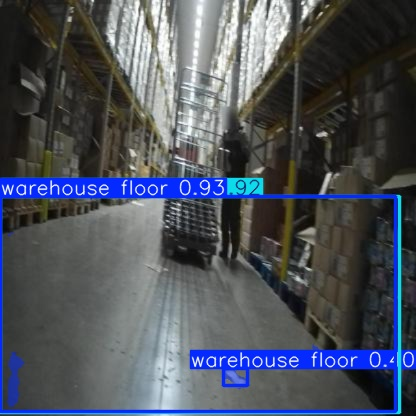

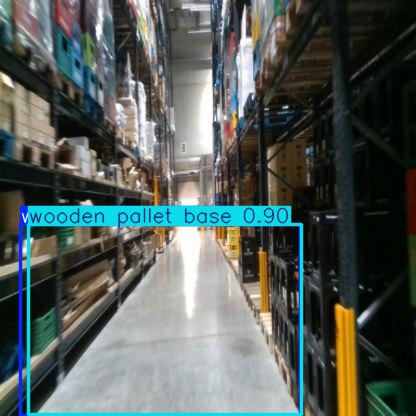

In [ ]:
for image_path in glob.glob(f'{HOME}/runs/segment/predict/*.jpg')[:3]:
    display(Image(filename=image_path, height=600))
    print("\n")

Extract mAP metrics from validation logs


In [ ]:
df = pd.read_csv('runs/segment/train/results.csv')
# print(df.columns)

print("\nValidation Metrics:")
print(f"Best Segmentation mAP50-95(B): {df['    metrics/mAP50-95(B)'].max():.4f}")
print(f"Best Segmentation mAP50-95(M): {df['    metrics/mAP50-95(M)'].max():.4f}")
print(f"Best Segmentation mAP50(B): {df['       metrics/mAP50(B)'].max():.4f}")
print(f"Best Segmentation mAP50(M): {df['       metrics/mAP50(M)'].max():.4f}")


Validation Metrics:
Best Segmentation mAP50-95(B): 0.4852
Best Segmentation mAP50-95(M): 0.3405
Best Segmentation mAP50(B): 0.5826
Best Segmentation mAP50(M): 0.4531
